# Interactive Play

Idea: define and play high-level moves and show the results before and after with some kind of rendering

In [2]:
import sys
sys.path.insert(0, "../")
import copy
import matplotlib.pyplot as plt
import numpy as np
from SC_Utils.game_utils import init_game, ObsProcesser
from SC_Utils.render import *
from Utils import test_SCEnv_motion as actions
from pysc2.lib import actions as sc_actions

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [36]:
class InteractivePlay():
    def __init__(self, map_name, screen_res, minimap_res, **kwargs):
        self.screen_res = screen_res
        self.minimap_res = minimap_res
        self.current_state = None
        self.last_state = None
        game_params = dict(feature_screen=screen_res, feature_minimap=minimap_res, action_space="FEATURES") 
        self.env = init_game(game_params, map_name=map_name, max_steps=256, random_seed=1)
        self.obs_proc = ObsProcesser(**kwargs)
        
    def reset(self, show_available=True):
        obs = self.env.reset()
        if show_available:
            print("Available actions: \n")
            for a in obs[0].observation.available_actions:
                print(sc_actions.FUNCTIONS[a])
        state, names = self.obs_proc.get_state(obs)
        self.current_state = state
        self.print_unit_positions(names)
        self.render(names)
        return
    
    def step(self, action, show_available=False):
        self.last_state = copy.deepcopy(self.current_state)
        print("Action taken: ", action[0])
        obs = self.env.step(actions=action)
        reward = obs[0].reward
        print("Reward: ", reward)
        if show_available:
            print("Control groups: ", obs[0].observation.control_groups)
            print("Available actions: \n")
            for a in obs[0].observation.available_actions:
                print(sc_actions.FUNCTIONS[a])
        state, names = self.obs_proc.get_state(obs)
        self.current_state = state
        return names
    
    def render(self, names, screen_only=True):
        self.render_screen(names)
        if not screen_only:
            self.render_minimap()
        plt.show()
        return
    
    def render_screen(self, names):
        plot_screen(self.current_state, names, self.last_state)
        return
    
    def render_minimap(self):
        raise Exception('Not implemented')
    
    def interactive_step(self, action, show_available=False):
        names = self.step(action, show_available)
        self.print_unit_positions(names)
        self.render(names)
        return
    
    def print_unit_positions(self, names):
        s = self.current_state['screen_layers']
        screen_names = names['screen_names']
        
        plot = True
        if 'player_relative_1' in screen_names:
            friendly_idx = np.where(screen_names == 'player_relative_1')[0]
            neutral_idx = np.where(screen_names == 'player_relative_3')[0]
            enemy_idx = np.where(screen_names == 'player_relative_4')[0]
        else:
            print("No player relative layer available")
            plot = False
            
        if plot:
            player_ys, player_xs = s[friendly_idx].reshape(s.shape[-2:]).nonzero()
            print("Friendly units positions: ")
            for x, y in zip(player_xs, player_ys):
                print('x,y: ', x,y)
                
            player_ys, player_xs = s[neutral_idx].reshape(s.shape[-2:]).nonzero()
            print("Neutral units positions: ", player_xs, player_ys)
                
            player_ys, player_xs = s[enemy_idx].reshape(s.shape[-2:]).nonzero()
            print("Enemy units positions: ")
            for x, y in zip(player_xs, player_ys):
                print('x,y: ', x,y)
        return
    
    def close(self):
        self.env.close()

In [37]:
map_name = 'CollectMineralShards'#'MoveToBeacon'
screen_res, minimap_res = 32, 32
screen_names = ['visibility_map', 'player_relative', 'unit_density','selected']
preproc_args = dict(screen_names=screen_names)

In [38]:
choices = ['upper-right',
           'upper-center',
           'upper-left',
           'middle-right',
           'middle-center',
           'middle-left',
           'lower-right',
           'lower-center',
           'lower-left']

RESOLUTION = screen_res
yx_points_dict = { 'upper-right':[0, RESOLUTION-1],
                   'upper-center':[0, RESOLUTION//2],
                   'upper-left':[0,0],
                   'middle-right':[RESOLUTION//2, RESOLUTION-1],
                   'middle-center':[RESOLUTION//2, RESOLUTION//2],
                   'middle-left':[RESOLUTION//2, 0],
                   'lower-right':[RESOLUTION-1,RESOLUTION-1],
                   'lower-center':[RESOLUTION-1,RESOLUTION//2],
                   'lower-left':[RESOLUTION-1, 0] 
                 }

Note: after some experiments it appears that clicking on top of a mineral shard somehow is prohibited (in the sense that the resulting action is null).

## Example 1 - Control group actions
Action: 4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])

control_group_act meanings:
- recall, set, append, set_and_steal, append_and_steal

So probably to create a control group you first select maunally the units and then you play select_control_group([[ set ], [ 0 ]]) to assign the selected unit to control group 0. **Verified in the example above.**

Question: how is it possible to recognize which unit is inside which control group? 

In [39]:
iplay = InteractivePlay(map_name, screen_res, minimap_res, **preproc_args)

Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
7/select_army (7/select_add [2])
Friendly units positions: 
x,y:  14 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


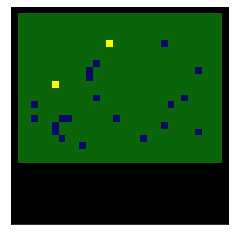

In [40]:
iplay.reset()

Action taken:  FunctionCall(function=3, arguments=[[0], [12, 4], [16, 6]])
Reward:  0
Control groups:  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
453/Stop_quick (3/queued [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
7/select_army (7/select_add [2])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
Friendly units positions: 
x,y:  14 5
x,y:  6 11
Neutral unit

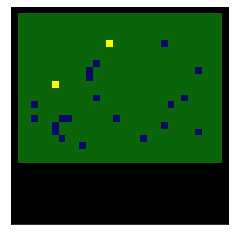

In [41]:
a_id = 3
a_args = [[0],[12,4],[16,6]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=4, arguments=[[1], [0]])
Reward:  0
Friendly units positions: 
x,y:  14 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


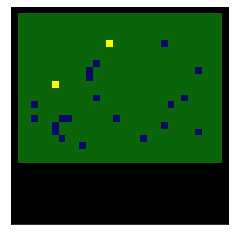

In [42]:
# select_control_group - set new control group
a_id = 4
a_args = [[1],[0]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [23, 5]])
Reward:  0
Friendly units positions: 
x,y:  16 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


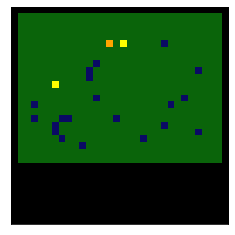

In [43]:
a = actions.move(point=[23,5]) # xfirst
iplay.interactive_step(a)

Action taken:  FunctionCall(function=3, arguments=[[0], [5, 10], [7, 12]])
Reward:  0
Control groups:  [[48  1]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]]
Available actions: 

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
453/Stop_quick (3/queued [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
7/select_army (7/select_add [2])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
Friendly units positions: 
x,y:  17 5
x,y

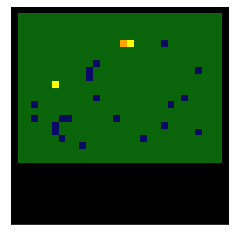

In [44]:
# use select rectangle to select the other unit
a_id = 3
a_args = [[0],[5,10],[7,12]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

Action taken:  FunctionCall(function=4, arguments=[[1], [1]])
Reward:  0
Friendly units positions: 
x,y:  19 5
x,y:  6 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


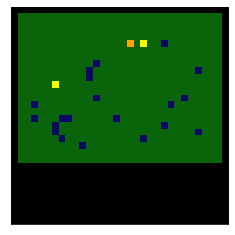

In [45]:
# select_control_group - set new control group
a_id = 4
a_args = [[1],[1]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [3, 12]])
Reward:  0
Friendly units positions: 
x,y:  20 5
x,y:  5 11
Neutral units positions:  [22 12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 5  8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


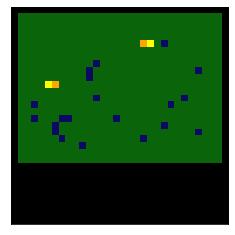

In [46]:
a = actions.move([3,12]) # xfirst
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=4, arguments=[[0], [0]])
Reward:  1
Friendly units positions: 
x,y:  22 5
x,y:  4 12
Neutral units positions:  [12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


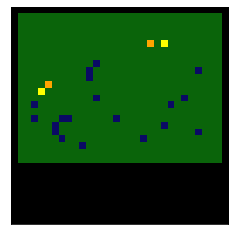

In [47]:
# Now we select once again the first unit
# select_control_group - set new control group
a_id = 4
a_args = [[0],[0]] #(select, group 0)
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a)

Action taken:  FunctionCall(function=<_Functions.Attack_screen: 12>, arguments=[[0], [27, 10]])
Reward:  0
Friendly units positions: 
x,y:  23 6
x,y:  3 12
Neutral units positions:  [12 11 27 11 12 25  3 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9  9 10 13 13 14 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


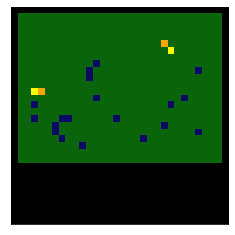

In [48]:
a = actions.move([27,10]) # xfirst
iplay.interactive_step(a, show_available=False)

Action taken:  FunctionCall(function=<_Functions.no_op: 0>, arguments=[])
Reward:  1
Friendly units positions: 
x,y:  26 9
x,y:  3 12
Neutral units positions:  [12 11 11 12 25 23  3  7  8 15  6 22  6 27  7 19 10] [ 8  9 10 13 13 14 16 16 16 16 17 17 18 18 19 19 20]
Enemy units positions: 


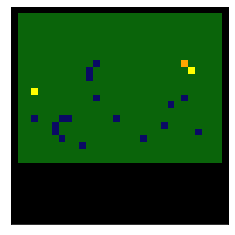

In [51]:
a = actions.no_op()
iplay.interactive_step(a)

It seems that unlike in real game, trying to select a point or rectangle that does not contain units doesn't deselect the current unit. So basically with this action space and a single unit, you have to select your unit once and it will remain selected untill the end of the episode.

In [52]:
iplay.close()

In [ ]:
# Other possible actions

In [ ]:
a_id = 3
a_args = [[0],[12,4],[16,6]]
a = [sc_actions.FunctionCall(a_id, a_args)]
iplay.interactive_step(a, show_available=True)

In [ ]:
a = actions.select()
iplay.interactive_step(a, show_available=False)

In [ ]:
p = yx_points_dict['lower-center']
print(p[1])
a = actions.move([p[1],p[0]]) # xfirst
print(a)
iplay.interactive_step(a, show_available=False)

Actions checked:
- 0/no_op ()
- 2/select_point (6/select_point_act [4]; 0/screen [0, 0])
- 3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
- 4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
- 7/select_army (7/select_add [2])
- 12/Attack_screen (3/queued [2]; 0/screen [0, 0])


Other actions to check:
- 1/move_camera (1/minimap [0, 0]) - shows on the screen the part of the minimap in which it has clicked
- 453/Stop_quick (3/queued [2]) - stops the unit in place
- 451/Smart_screen (3/queued [2]; 0/screen [0, 0]) - no idea
- 452/Smart_minimap (3/queued [2]; 1/minimap [0, 0]) - no idea
- 331/Move_screen (3/queued [2]; 0/screen [0, 0]) - moves selected unit on that point of the screen
- 332/Move_minimap (3/queued [2]; 1/minimap [0, 0]) - moves selected unit on that point of the minimap
- 333/Patrol_screen (3/queued [2]; 0/screen [0, 0]) - goes back and forth from the current position and the one that has clicked on the screen
- 334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0]) - goes back and forth from the current position and the one that has clicked on the minimap
- 13/Attack_minimap (3/queued [2]; 1/minimap [0, 0]) - moves selected unit on that point of the minimap while engaging in combat
- 274/HoldPosition_quick (3/queued [2]) - forces unit to hold position (instead of going automatically against enemy troops?)

So either we try to get the action space as big as possible or we enlarge it just enough to contain optimal strategies.

**Optimal strategies**:
- micromanagement of units (e.g. in CollectMineralShards the gathering of shards is immediate, so to have the two agents in 2 different places going after 2 different shards should be better) -> granular selection (can be done with select point and select rectangle, onestly between the 2 I would use the rectangle because it's easier)



In [9]:
# Objective: create list of action ids that we want to use in the game

# Ex1: no_op, select_army, attack_screen, Move_screen
_NO_OP = sc_actions.FUNCTIONS['no_op'].id
_SELECT_ARMY = sc_actions.FUNCTIONS['select_army'].id
_ATTACK_SCREEN = sc_actions.FUNCTIONS['Attack_screen'].id
_MOVE_SCREEN = sc_actions.FUNCTIONS['Move_screen'].id

In [11]:
action_names = ['no_op', 'select_army', 'Attack_screen', 'Move_screen']

In [12]:
action_ids = [sc_actions.FUNCTIONS[a_name].id for a_name in action_names]
action_ids

[<_Functions.no_op: 0>,
 <_Functions.select_army: 7>,
 <_Functions.Attack_screen: 12>,
 <_Functions.Move_screen: 331>]

In [16]:
# this needs to be passed both to each worker to compute get_action_mask() func and to SpatialActorCritic
action_dict = {i:action_ids[i] for i in range(len(action_ids))}
type(action_dict)

dict